<a href="https://colab.research.google.com/github/AnastasiaBrinati/experiments/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 **PROVA MODELLI CENTRALIZZATI PREDIZIONE INVOCATIONS' RATE**



#### Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from keras import layers
from tensorflow.keras.callbacks import EarlyStopping

!pip install -q -U keras-tuner
import keras_tuner as kt

# Use seaborn for pairplot.
!pip install datasets

from datasets import load_dataset

# Data

In [20]:
dataset_120 = load_dataset("anastasiafrosted/globus_120", download_mode="force_redownload")
dataset_300 = load_dataset("anastasiafrosted/globus_300", download_mode="force_redownload")

df_120 = pd.DataFrame(dataset_120['train'])
df_300 = pd.DataFrame(dataset_300['train'])

# Ensure the `timestamp` column is in datetime format
df_120['timestamp'] = pd.to_datetime(df_120['timestamp'])
df_300['timestamp'] = pd.to_datetime(df_300['timestamp'])

train-00000-of-00001.parquet:   0%|          | 0.00/1.75M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/90833 [00:00<?, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/996k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/37667 [00:00<?, ? examples/s]

In [21]:
data = df_120
data = data.set_index("timestamp")
freq='120s'

In [22]:
origin = "2023-06-15"
start = "2023-07-02" # origin + prediction_lenght
end = "2023-07-08"

train_data = data["2022-12-20":origin]
valid_data = data[origin:start]
test_data = data[start:]

#### Scaling

In [23]:
from sklearn.preprocessing import StandardScaler

# Crea un'istanza dello scaler
scaler = StandardScaler()

# Per il dataset di training
scaled_train = train_data.copy()
scaled_train[scaled_train.columns.drop('avg_invocations_rate')] = scaler.fit_transform(
    train_data[train_data.columns.drop('avg_invocations_rate')]
)
train = scaled_train

# Per il dataset di validazione
scaled_valid = valid_data.copy()
scaled_valid[scaled_valid.columns.drop('avg_invocations_rate')] = scaler.transform(
    valid_data[valid_data.columns.drop('avg_invocations_rate')]
)
valid = scaled_valid

# Per il dataset di test
scaled_test = test_data.copy()
scaled_test[scaled_test.columns.drop('avg_invocations_rate')] = scaler.transform(
    test_data[test_data.columns.drop('avg_invocations_rate')]
)
test = scaled_test

#### Config (Parameters)

In [24]:
batch_size = 32
num_features = 6
sequence_lenght = 7
prediction_lenght = 7

seed = 123
neurons = 32
epochs = 10

# Models

## Forecasting one-step-ahead

In [25]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate=0.01, epochs=epochs):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=10, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

### Univariate series

In [26]:
tr = train['avg_invocations_rate']
vl = valid['avg_invocations_rate']
ts = test['avg_invocations_rate'][:-1]

In [27]:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    tr.to_numpy(),
    targets=tr[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    vl.to_numpy(),
    targets=vl[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_ds = tf.keras.utils.timeseries_dataset_from_array(
    ts.to_numpy(),
    targets=ts[sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Linear Model

In [28]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[sequence_lenght])
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
fit_and_evaluate(model, train_ds, valid_ds)

Epoch 1/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.0034 - mae: 0.0431 - val_loss: 9.5087e-04 - val_mae: 0.0217
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 0.0016 - mae: 0.0286 - val_loss: 7.2881e-04 - val_mae: 0.0195
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - loss: 0.0013 - mae: 0.0259 - val_loss: 6.6062e-04 - val_mae: 0.0181
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.0012 - mae: 0.0250 - val_loss: 6.3151e-04 - val_mae: 0.0170
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0012 - mae: 0.0246 - val_loss: 6.2889e-04 - val_mae: 0.0175
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.0012 - mae: 0.0245 - val_loss: 6.1763e-04 - val_mae: 0.0167
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0012 - mae: 0.0244 - val_loss: 6.1121e-04 - val_mae: 0.0163
Epoch 8/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.0012 - mae: 0.0243 - val_loss: 6.0896e-04 - val_mae: 0.016

16112.765297293663

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


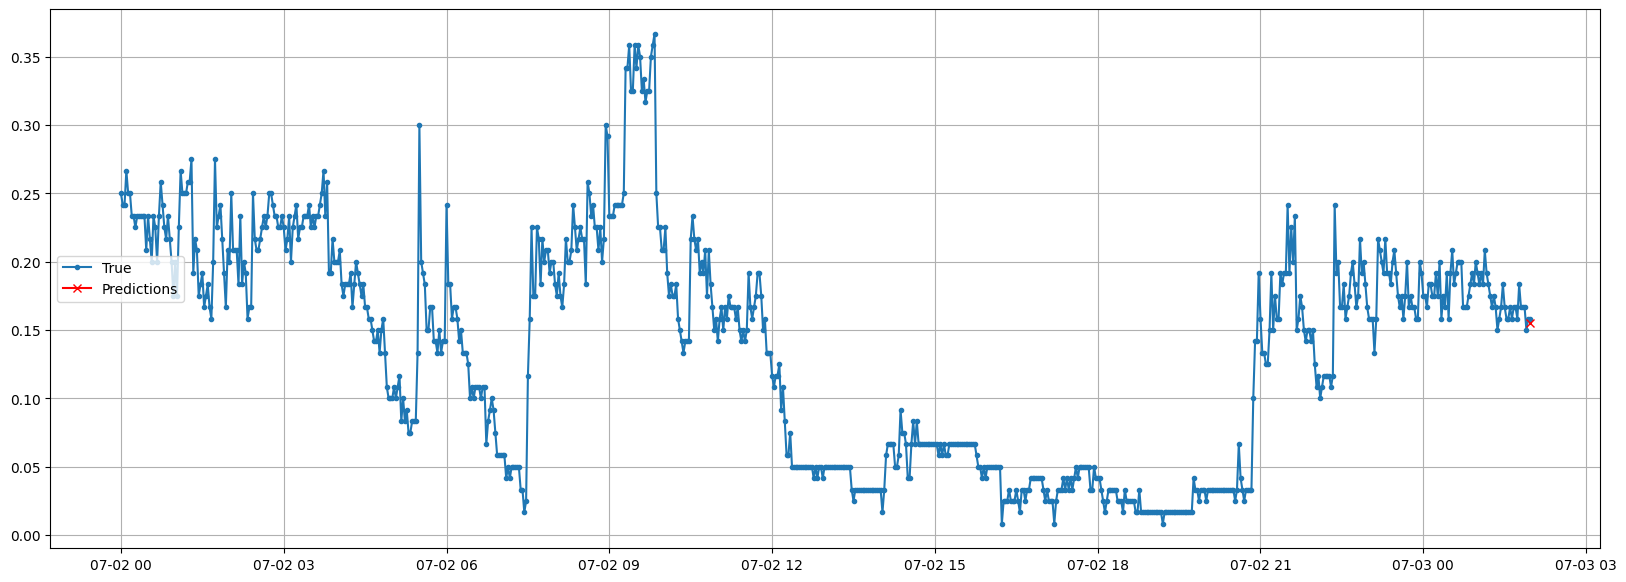

In [30]:
Y_pred = model.predict(test_ds)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test.index[-1], end=test.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

#### Simple RNN

Recall that the input_shape argument ignores
the first dimension (i.e., the batch size), and since recurrent layers can accept
input sequences of any length, we can set the second dimension to None, which
means “any size”. Lastly, since we’re dealing with a univariate time series, we
need the last dimension’s size to be 1. This is why we specified the input shape
* [None, 1] : it means “univariate sequences of any length”.


In [31]:
univar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons*2, input_shape=[None, 1]),
  tf.keras.layers.Dense(1) # no activation function by default
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
fit_and_evaluate(univar_model, train_ds, valid_ds)

Epoch 1/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0015 - mae: 0.0283 - val_loss: 6.2230e-04 - val_mae: 0.0149
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0013 - mae: 0.0253 - val_loss: 6.3082e-04 - val_mae: 0.0176
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0012 - mae: 0.0251 - val_loss: 6.3232e-04 - val_mae: 0.0161
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.0012 - mae: 0.0249 - val_loss: 6.0994e-04 - val_mae: 0.0145
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.0012 - mae: 0.0247 - val_loss: 6.4869e-04 - val_mae: 0.0171
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 0.0012 - mae: 0.0247 - val_loss: 6.0729e-04 - val_mae: 0.0151
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.0012 - mae: 0.0246 - val_loss: 6.8745e-04 - val_mae: 0.0192
Epoch 8/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - loss: 0.0012 - mae: 0.0248 - val_loss: 6.1482e-04 - val_mae: 0.0169


14538.238756358624

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


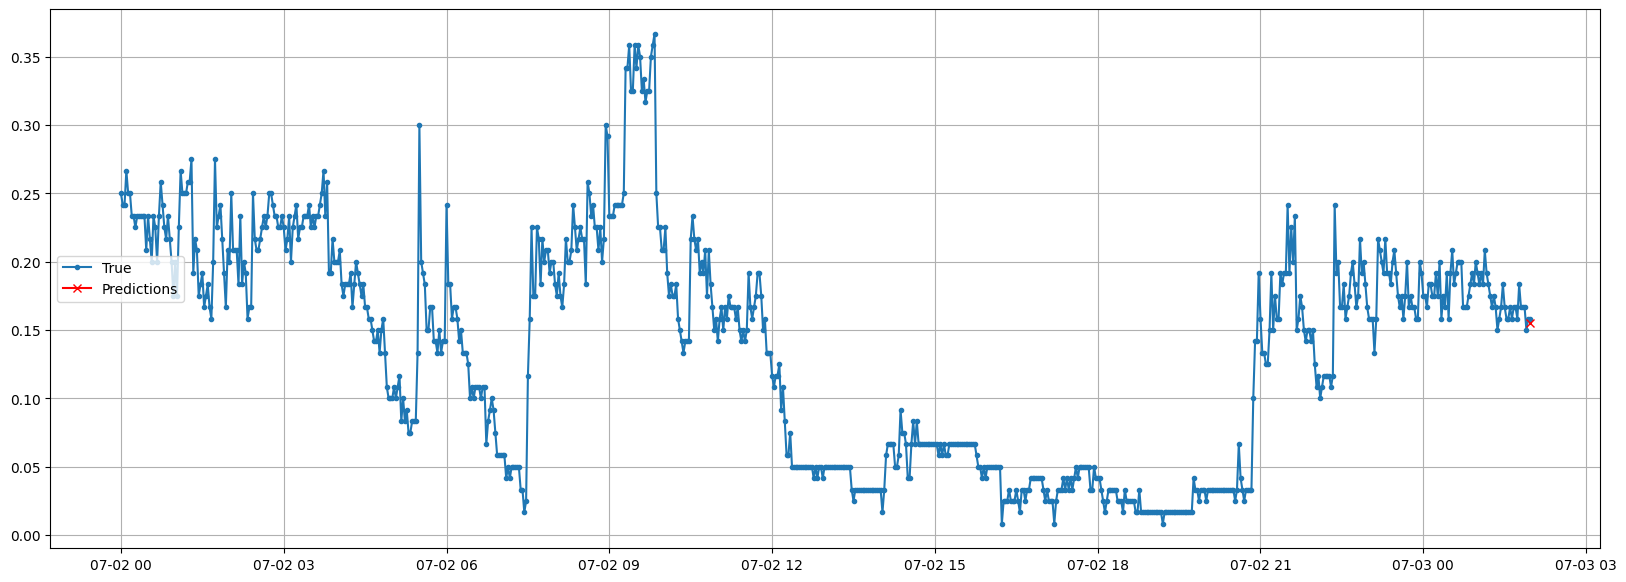

In [33]:
Y_pred = univar_model.predict(test_ds)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test.index[-1], end=test.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

#### Deep RNN

In [34]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(neurons*3, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(neurons*2, return_sequences=True),
    tf.keras.layers.SimpleRNN(neurons),
    tf.keras.layers.Dense(1)
])

In [35]:
fit_and_evaluate(deep_model, train_ds, valid_ds)

Epoch 1/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.0030 - mae: 0.0393 - val_loss: 6.4300e-04 - val_mae: 0.0164
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 0.0013 - mae: 0.0272 - val_loss: 7.5643e-04 - val_mae: 0.0250
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - loss: 0.0013 - mae: 0.0267 - val_loss: 5.9946e-04 - val_mae: 0.0148
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 0.0013 - mae: 0.0265 - val_loss: 6.2507e-04 - val_mae: 0.0158
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - loss: 0.0012 - mae: 0.0264 - val_loss: 6.1034e-04 - val_mae: 0.0150
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 0.0012 - mae: 0.0260 - val_loss: 6.0537e-04 - val_mae: 0.0147
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 42s 15ms/step - loss: 0.0012 - mae: 0.0260 - val_loss: 6.0871e-04 - val_mae: 0.0151
Epoch 8/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.0012 - mae: 0.0259 - val_loss: 6.1851e-04 - val_mae:

14725.840650498867

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


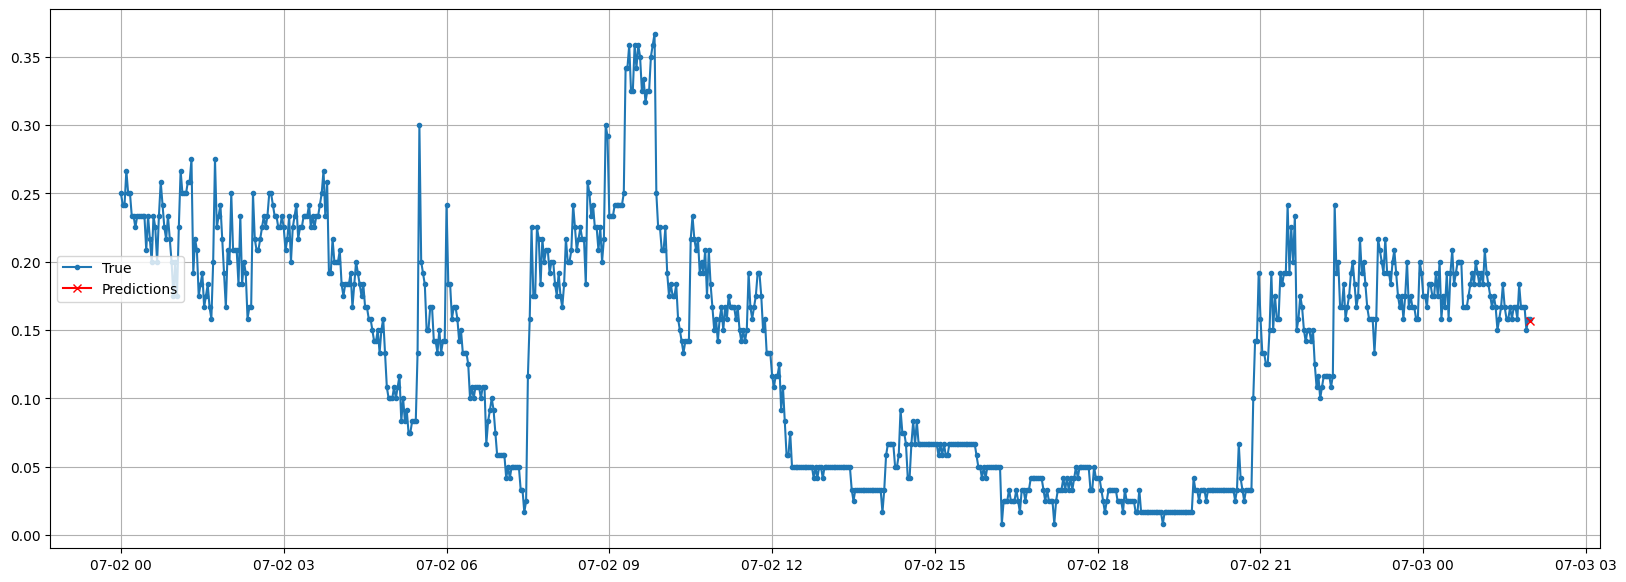

In [36]:
Y_pred = deep_model.predict(test_ds)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test.index[-1], end=test.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

### Multivariate Series

In [37]:
tf.random.set_seed(seed)  # extra code – ensures reproducibility
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    train,
    targets=train['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid,
    targets=valid['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)
test_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    test,
    targets=test['avg_invocations_rate'][sequence_lenght:],
    sequence_length=sequence_lenght,
    batch_size=batch_size
)

#### Simple RNN

Notice that the only difference from the univar_model RNN we built earlier
is the input shape: at each time step, the model now receives num_features inputs instead of one.

In [38]:
mulvar_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons, input_shape=[None, num_features]),
  tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds)

Epoch 1/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0130 - mae: 0.0686 - val_loss: 6.6598e-04 - val_mae: 0.0168
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0014 - mae: 0.0280 - val_loss: 6.2659e-04 - val_mae: 0.0162
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.0013 - mae: 0.0266 - val_loss: 6.3338e-04 - val_mae: 0.0171
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0012 - mae: 0.0258 - val_loss: 6.5298e-04 - val_mae: 0.0185
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0012 - mae: 0.0254 - val_loss: 6.1819e-04 - val_mae: 0.0171
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - loss: 0.0012 - mae: 0.0251 - val_loss: 6.0789e-04 - val_mae: 0.0154
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0012 - mae: 0.0248 - val_loss: 6.0292e-04 - val_mae: 0.0152
Epoch 8/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0012 - mae: 0.0247 - val_loss: 5.9991e-04 - val_mae: 0.0151


15149.345621466637

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


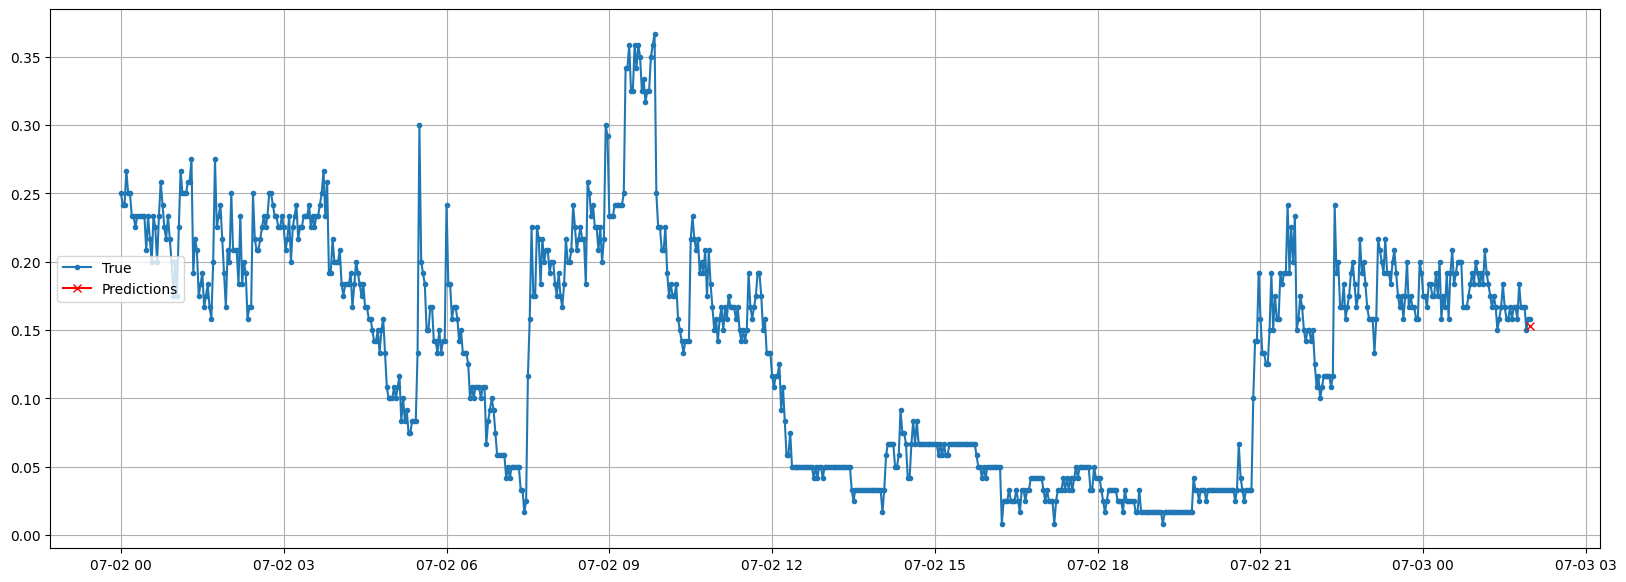

In [40]:
Y_pred = mulvar_model.predict(test_mulvar_ds)
Y_pred = pd.Series(Y_pred[-1], index=pd.date_range(start=test.index[-1], end=test.index[-1]))

fig, ax = plt.subplots(figsize=(20, 7))
plt.plot(test['avg_invocations_rate'], label="True", marker=".")
plt.plot(Y_pred, label="Predictions", marker="x", color="r")
plt.legend(loc="center left")
plt.grid()
plt.show()

## Forecasting Several Time Steps Ahead

### Univariate Series

Consideriamo sempre:
* tr = train['avg_invocations_rate']
* vl = valid['avg_invocations_rate']

#### Simple RNN

The first option is to take the univar_model RNN we trained earlier for the
rail time series, make it predict the next value, and add that value to the inputs,
acting as if the predicted value had actually occurred; we would then use the
model again to predict the following value, and so on.

---
If the model makes an error at one time step, then the forecasts for the
following time steps are impacted as well: the errors tend to accumulate.
So, it’s preferable to use this technique only for a small number of steps.

 1 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
 2 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
 3 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
 4 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
 5 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
 6 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
 7 step ahead
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


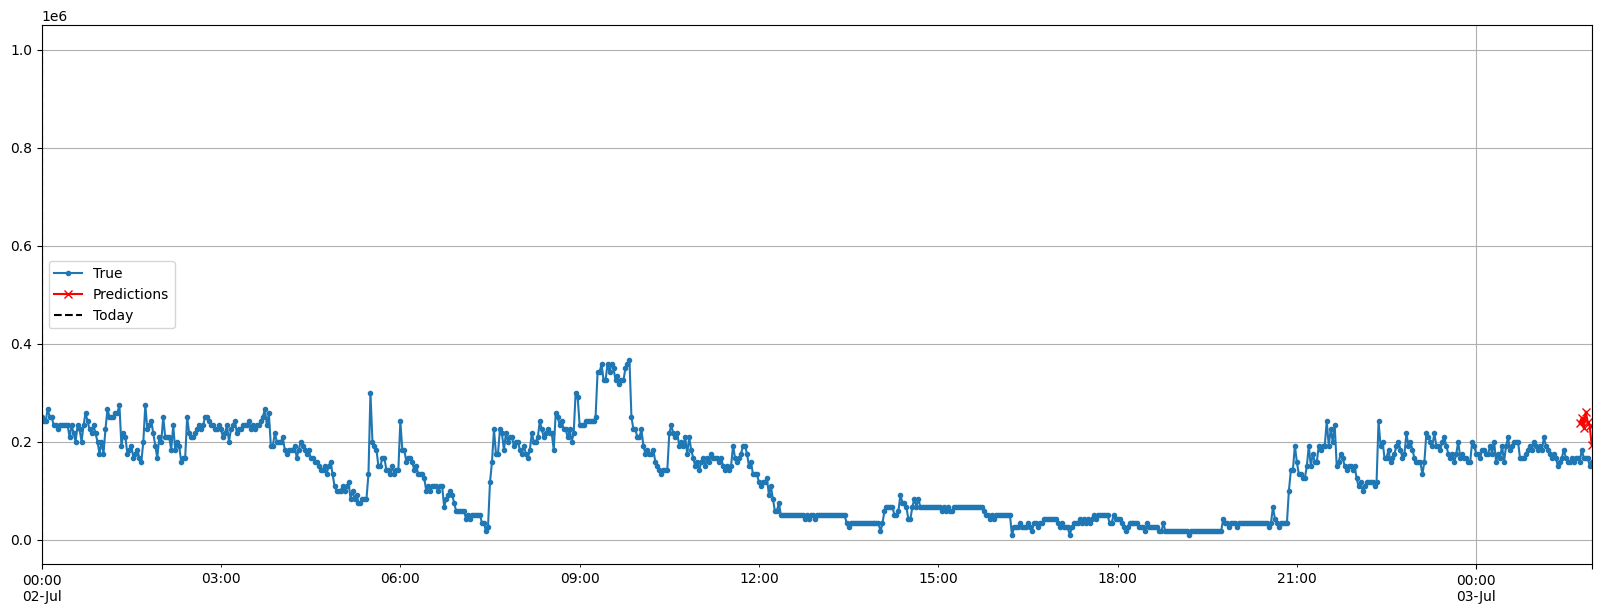

In [41]:
X = ts[:-sequence_lenght].to_numpy()[np.newaxis, :sequence_lenght, np.newaxis]
for step_ahead in range(prediction_lenght):
  print(f" {step_ahead+1} step ahead")
  y_pred_one = univar_model.predict(X)
  X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

Y_pred = pd.Series(X[0, -prediction_lenght:, 0], index=pd.date_range(start=ts.index[-sequence_lenght], end=ts.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, 0, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

### Multivariate Series

In [42]:
def split_inputs_and_targets(mulvar_series, ahead=prediction_lenght, target_col=1):
  return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    train,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size,
    shuffle=True,
    seed=seed
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

ahead_test_ds = tf.keras.utils.timeseries_dataset_from_array(
    test,
    targets=None,
    sequence_length=sequence_lenght + prediction_lenght,
    batch_size=batch_size
).map(split_inputs_and_targets)

#### Sequence-to-Vector RNN

Train an RNN to predict the next 14 values in one shot.

In [43]:
ahead_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds)

Epoch 1/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - loss: 0.1728 - mae: 0.4010 - val_loss: 0.0569 - val_mae: 0.2098
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.1436 - mae: 0.3536 - val_loss: 0.0559 - val_mae: 0.2089
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.1415 - mae: 0.3490 - val_loss: 0.0535 - val_mae: 0.1727
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 0.1399 - mae: 0.3461 - val_loss: 0.0563 - val_mae: 0.2131
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.1390 - mae: 0.3446 - val_loss: 0.0533 - val_mae: 0.1745
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - loss: 0.1383 - mae: 0.3435 - val_loss: 0.0544 - val_mae: 0.1934
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - loss: 0.1380 - mae: 0.3430 - val_loss: 0.0574 - val_mae: 0.2231
Epoch 8/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.1373 - mae: 0.3421 - val_loss: 0.0559 - val_mae: 0.2094
Epoch 9/10
2499/2499 ━━━━━━━━━━━

172697.3056793213

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


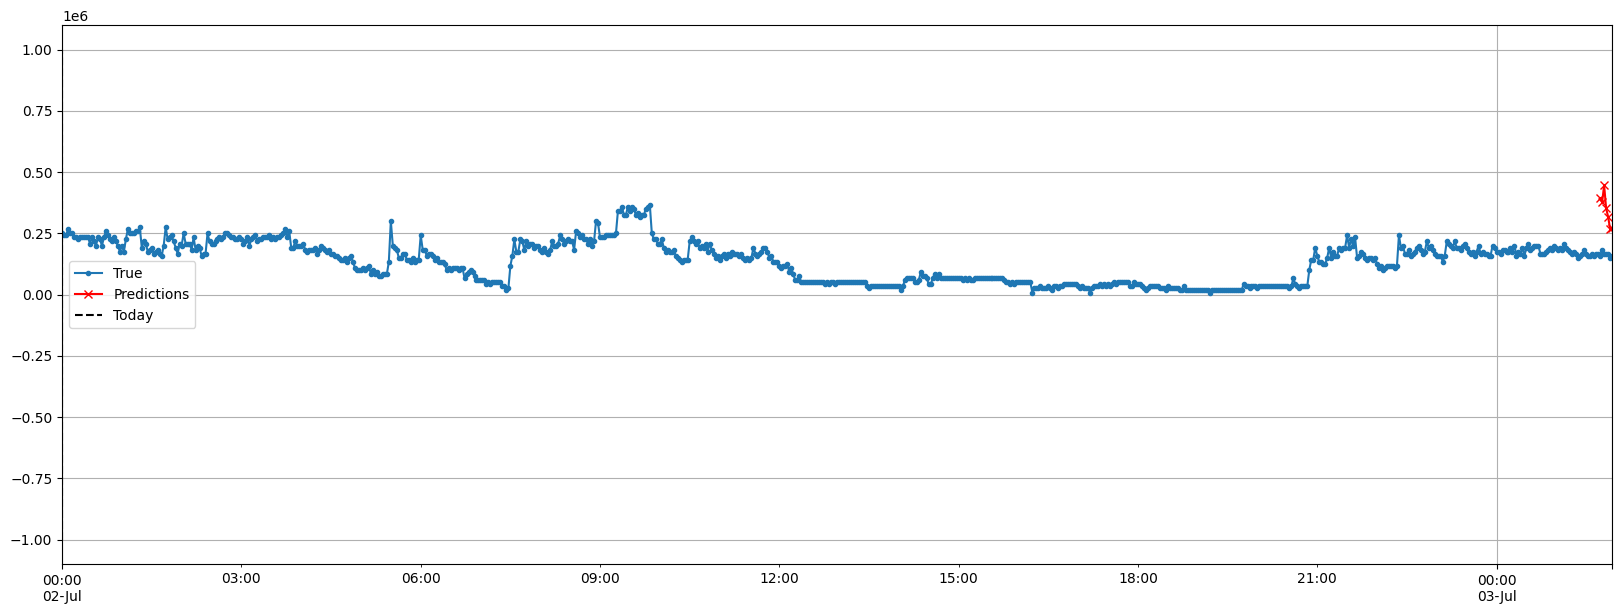

In [45]:
X = test.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = ahead_model.predict(X)
Y_pred = pd.Series(Y_pred[0], index=pd.date_range(start=ts.index[-sequence_lenght], end=ts.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### Sequence-to-Sequence RNN

In [46]:
def to_windows(dataset, length):
  dataset = dataset.window(length, shift=1, drop_remainder=True)
  return dataset.flat_map(lambda window_ds: window_ds.batch(length))

def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1, batch_size=32, shuffle=False, seed=None):
  ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
  ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
  if shuffle:
    ds = ds.shuffle(8 * batch_size, seed=seed)
  return ds.batch(batch_size)

In [47]:
seq2seq_train = to_seq2seq_dataset(train, seq_length=sequence_lenght, ahead=prediction_lenght, shuffle=True, seed=seed)
seq2seq_valid = to_seq2seq_dataset(valid, seq_length=sequence_lenght, ahead=prediction_lenght)
seq2seq_test = to_seq2seq_dataset(test, seq_length=sequence_lenght, ahead=prediction_lenght)

Instead of training the model to forecast the next 14 values only at the very last time step, we can train it to forecast the next 14 values at each and every time step.
In other words, we can turn this sequence-to-vector RNN into a sequence-to-sequence RNN.

* The targets are sequences of consecutive windows, shifted by one time step at each time step;
* The target is not a vector anymore, but a sequence of the same length as the inputs, containing a (prediction_lenght)-dimensional vector at each step.

It is almost identical to our previous model: the only difference is that we set
return_sequences=True in the SimpleRNN layer. This way, it will
output a sequence of vectors (each of size 'batch_size'), instead of outputting a single
vector at the last time step. The Dense layer is smart enough to handle
sequences as input: it will be applied at each time step, taking a 'batch_size'-dimensional
vector as input and outputting a 'prediction_lenght'-dimensional vector.

In [48]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(neurons, return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [49]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid)

Epoch 1/10
   2493/Unknown 25s 9ms/step - loss: 0.1841 - mae: 0.4294

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2499/2499 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - loss: 0.1840 - mae: 0.4293 - val_loss: 0.0560 - val_mae: 0.1935
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - loss: 0.1498 - mae: 0.3703 - val_loss: 0.0550 - val_mae: 0.1987
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.1460 - mae: 0.3649 - val_loss: 0.0547 - val_mae: 0.1929
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.1447 - mae: 0.3628 - val_loss: 0.0546 - val_mae: 0.1916
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - loss: 0.1433 - mae: 0.3603 - val_loss: 0.0549 - val_mae: 0.1947
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - loss: 0.1425 - mae: 0.3588 - val_loss: 0.0546 - val_mae: 0.1882
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - loss: 0.1418 - mae: 0.3574 - val_loss: 0.0546 - val_mae: 0.1895
Epoch 8/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - loss: 0.1413 - mae: 0.3565 - val_loss: 0.0548 - val_mae: 0.1912
Epoch 9/10
2499/2499 ━━━━━━━━━━━━━━

188160.44926643372

Perchè sembra migliorare? dovrebbe peggiorare (?)

In [50]:
Y_pred_valid = seq2seq_model.predict(seq2seq_test)
for ahead in range(prediction_lenght):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=test.index[sequence_lenght + ahead : -prediction_lenght + ahead])
    mae = (preds - test["avg_invocations_rate"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
MAE for +1: 267,092
MAE for +2: 269,558
MAE for +3: 262,233
MAE for +4: 250,803
MAE for +5: 253,130
MAE for +6: 275,920
MAE for +7: 236,210


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


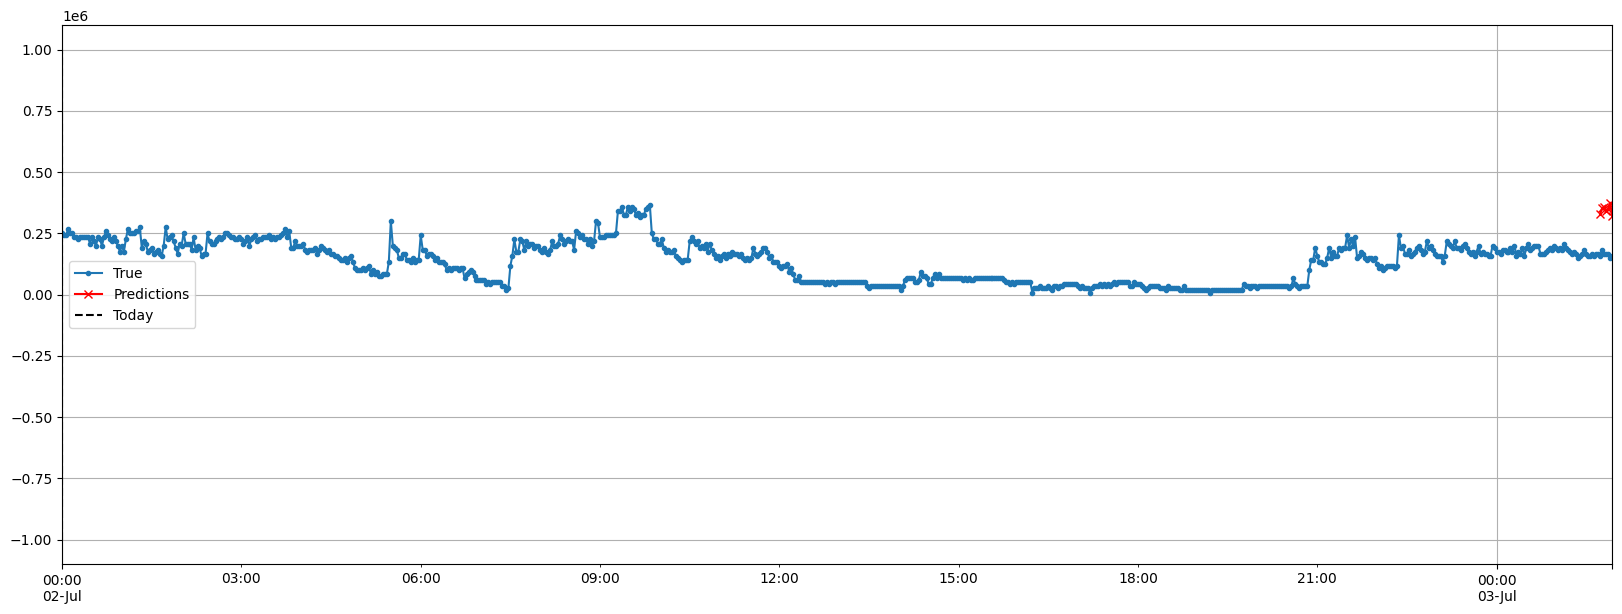

In [51]:
X = test.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts.index[-sequence_lenght], end=ts.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### RNN with layer normalization

In [52]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [53]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(neurons), return_sequences=True, input_shape=[None, num_features]),
    tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [54]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid)

Epoch 1/10
   2490/Unknown 31s 12ms/step - loss: 0.1975 - mae: 0.4475

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2499/2499 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - loss: 0.1974 - mae: 0.4473 - val_loss: 0.0566 - val_mae: 0.1879
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 37s 15ms/step - loss: 0.1482 - mae: 0.3692 - val_loss: 0.0558 - val_mae: 0.1883
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step - loss: 0.1451 - mae: 0.3637 - val_loss: 0.0560 - val_mae: 0.1924
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 0.1435 - mae: 0.3615 - val_loss: 0.0552 - val_mae: 0.1820
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - loss: 0.1423 - mae: 0.3590 - val_loss: 0.0553 - val_mae: 0.1902
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - loss: 0.1414 - mae: 0.3576 - val_loss: 0.0554 - val_mae: 0.1949
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.1411 - mae: 0.3569 - val_loss: 0.0550 - val_mae: 0.1884
Epoch 8/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.1408 - mae: 0.3557 - val_loss: 0.0552 - val_mae: 0.1917
Epoch 9/10
2499/2499 ━━━━━━━━━━━━━━

181995.04911899567

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


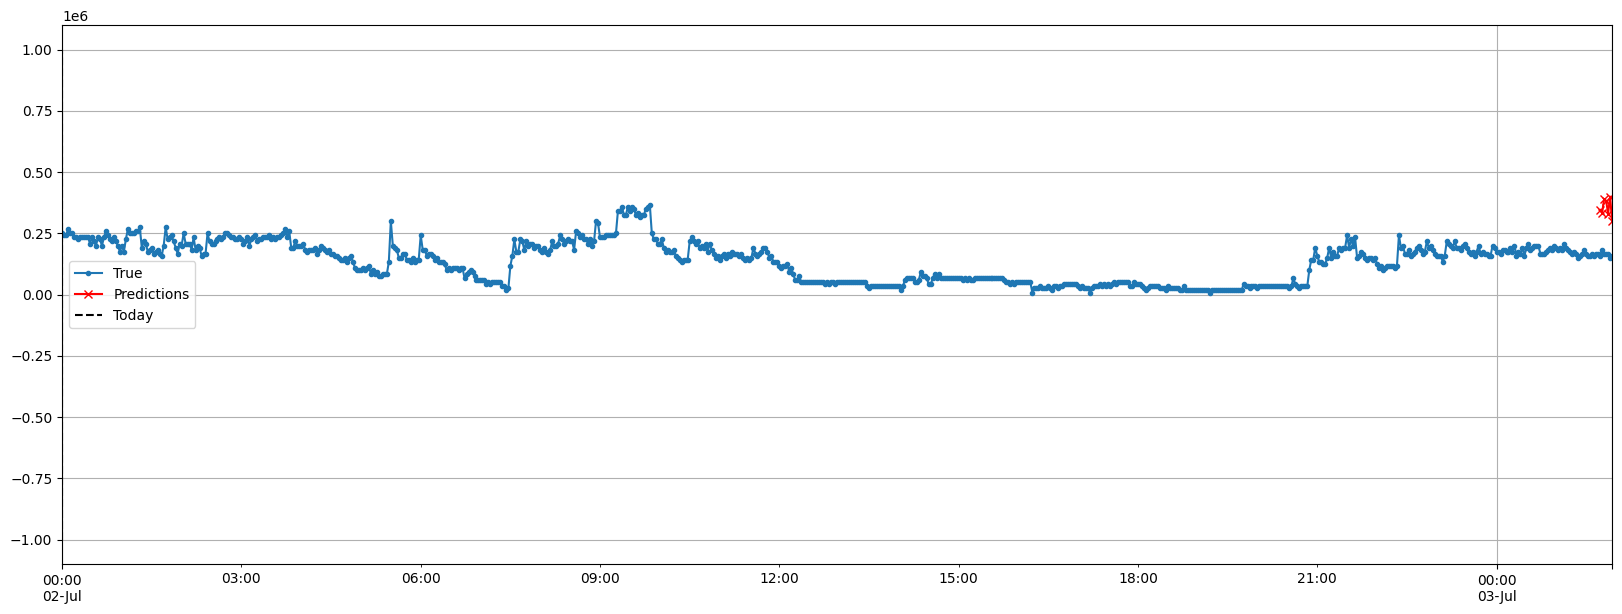

In [55]:
X = test.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = custom_ln_model.predict(X)  # but then [0, -1] because only the last time step's output

Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts.index[-sequence_lenght], end=ts.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

 #### LSTM

In [56]:
lstm = tf.keras.Sequential([
  tf.keras.layers.LSTM(neurons, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [57]:
fit_and_evaluate(lstm, seq2seq_train, seq2seq_valid)

Epoch 1/10
   2494/Unknown 30s 11ms/step - loss: 0.2058 - mae: 0.4597

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2499/2499 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - loss: 0.2057 - mae: 0.4596 - val_loss: 0.0591 - val_mae: 0.2103
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 0.1572 - mae: 0.3791 - val_loss: 0.0581 - val_mae: 0.2116
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 42s 13ms/step - loss: 0.1530 - mae: 0.3736 - val_loss: 0.0577 - val_mae: 0.2108
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - loss: 0.1508 - mae: 0.3702 - val_loss: 0.0570 - val_mae: 0.2095
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.1493 - mae: 0.3674 - val_loss: 0.0573 - val_mae: 0.2094
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - loss: 0.1482 - mae: 0.3656 - val_loss: 0.0567 - val_mae: 0.2066
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 0.1474 - mae: 0.3639 - val_loss: 0.0568 - val_mae: 0.2077
Epoch 8/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - loss: 0.1467 - mae: 0.3625 - val_loss: 0.0564 - val_mae: 0.2070
Epoch 9/10
2499/2499 ━━━━━━━━━━━━━━

204736.18805408478

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step


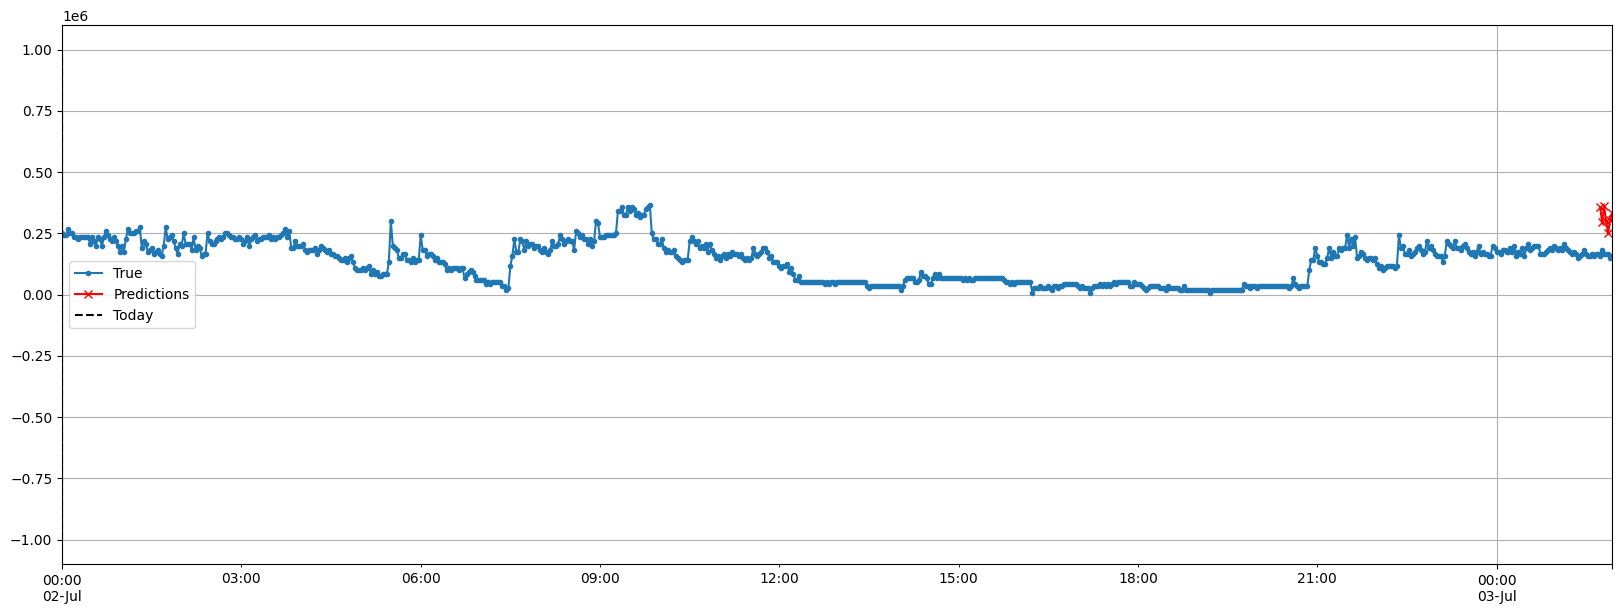

In [58]:
X = test.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = lstm.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts.index[-sequence_lenght], end=ts.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### GRU

The GRU cell is a simplified version of the LSTM cell...

In [59]:
gru = tf.keras.Sequential([
  tf.keras.layers.GRU(neurons, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [60]:
fit_and_evaluate(gru, seq2seq_train, seq2seq_valid)

Epoch 1/10
   2492/Unknown 33s 13ms/step - loss: 0.1918 - mae: 0.4396

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2499/2499 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.1918 - mae: 0.4395 - val_loss: 0.0622 - val_mae: 0.2134
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 0.1630 - mae: 0.3895 - val_loss: 0.0601 - val_mae: 0.2090
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - loss: 0.1599 - mae: 0.3838 - val_loss: 0.0583 - val_mae: 0.2053
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 0.1553 - mae: 0.3765 - val_loss: 0.0575 - val_mae: 0.2067
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 33s 13ms/step - loss: 0.1512 - mae: 0.3707 - val_loss: 0.0568 - val_mae: 0.2051
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - loss: 0.1493 - mae: 0.3679 - val_loss: 0.0568 - val_mae: 0.2080
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step - loss: 0.1481 - mae: 0.3661 - val_loss: 0.0571 - val_mae: 0.2106
Epoch 8/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - loss: 0.1473 - mae: 0.3648 - val_loss: 0.0571 - val_mae: 0.2099
Epoch 9/10
2499/2499 ━━━━━━━━━━━━━━

205129.53400611877

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step


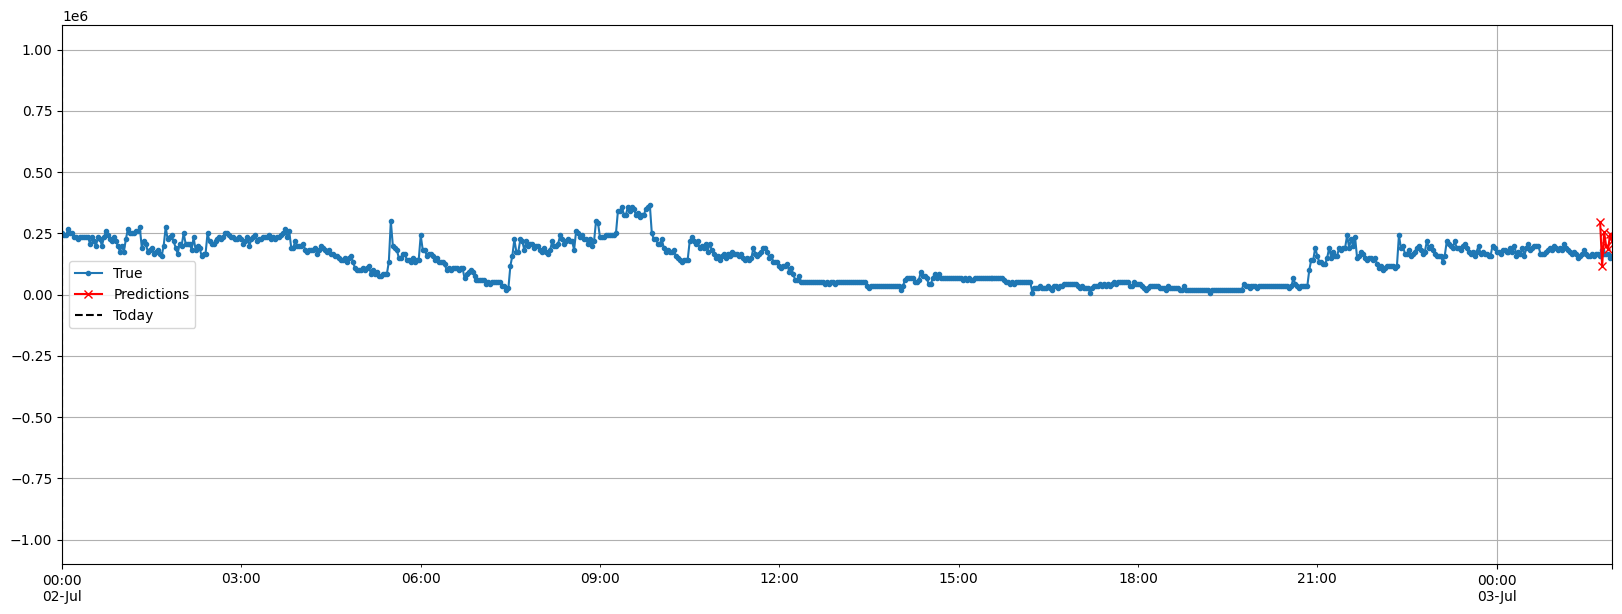

In [61]:
X = test.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = gru.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts.index[-sequence_lenght], end=ts.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

#### CNN

In [62]:
seq2seq_cnn_model = tf.keras.Sequential([
  tf.keras.layers.SimpleRNN(neurons*2, return_sequences=True, input_shape=[None, num_features]),
  tf.keras.layers.Conv1D(prediction_lenght, kernel_size=1)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [63]:
fit_and_evaluate(seq2seq_cnn_model, seq2seq_train, seq2seq_valid)

Epoch 1/10
   2491/Unknown 27s 10ms/step - loss: 0.1772 - mae: 0.4174

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2499/2499 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - loss: 0.1772 - mae: 0.4173 - val_loss: 0.0568 - val_mae: 0.1883
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - loss: 0.1506 - mae: 0.3722 - val_loss: 0.0544 - val_mae: 0.1770
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.1460 - mae: 0.3647 - val_loss: 0.0543 - val_mae: 0.1774
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - loss: 0.1435 - mae: 0.3604 - val_loss: 0.0540 - val_mae: 0.1648
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - loss: 0.1425 - mae: 0.3593 - val_loss: 0.0539 - val_mae: 0.1869
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - loss: 0.1420 - mae: 0.3582 - val_loss: 0.0538 - val_mae: 0.1803
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 29s 12ms/step - loss: 0.1410 - mae: 0.3566 - val_loss: 0.0542 - val_mae: 0.1899
Epoch 8/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step - loss: 0.1403 - mae: 0.3560 - val_loss: 0.0535 - val_mae: 0.1782
Epoch 9/10
2499/2499 ━━━━━━━━━━━━━━

164802.6406764984

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


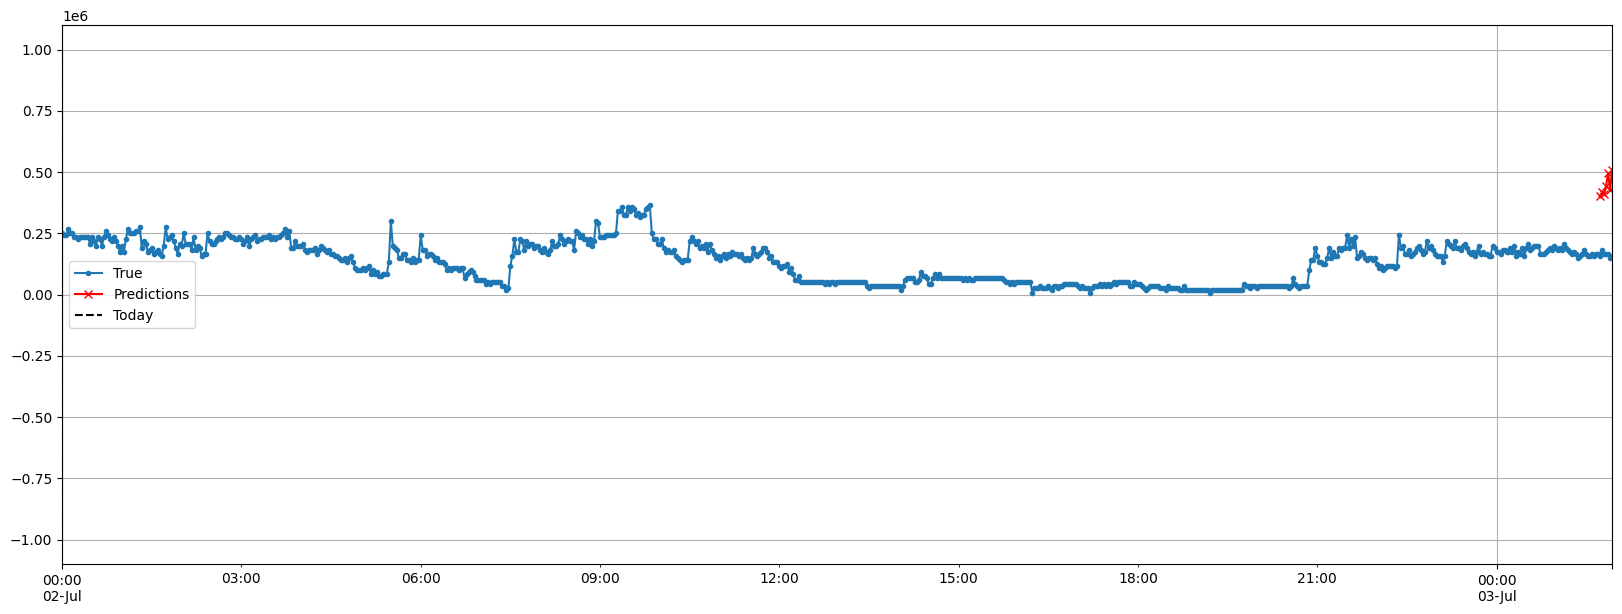

In [64]:
X = test.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = seq2seq_cnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts.index[-sequence_lenght], end=ts.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

LSTM and GRU cells are one of the main reasons behind the success of RNNs.
Yet while they can tackle much longer sequences than simple RNNs, they still
have a fairly limited short-term memory, and they have a hard time learning
long-term patterns in sequences of 100 time steps or more, such as audio
samples, long time series, or long sentences. One way to solve this is to shorten
the input sequences; for example, using 1D convolutional layers.

In [65]:
stride = 2
k_size = 4

conv_rnn_model = tf.keras.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=k_size, strides=stride, activation="relu", input_shape=[None, num_features]),
  tf.keras.layers.GRU(batch_size, return_sequences=True),
  tf.keras.layers.Dense(prediction_lenght)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [66]:
longer_train = to_seq2seq_dataset(train, seq_length=sequence_lenght*2, shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(valid, seq_length=sequence_lenght*2)
longer_test = to_seq2seq_dataset(test, seq_length=sequence_lenght*2)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))
downsampled_test = longer_test.map(lambda X, Y: (X, Y[:, (k_size-1)::stride, :prediction_lenght]))

In [67]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid)

Epoch 1/10
   2496/Unknown 35s 13ms/step - loss: 0.1690 - mae: 0.4038

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2499/2499 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - loss: 0.1689 - mae: 0.4037 - val_loss: 0.0541 - val_mae: 0.1974
Epoch 2/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 40s 15ms/step - loss: 0.1381 - mae: 0.3488 - val_loss: 0.0529 - val_mae: 0.1916
Epoch 3/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.1352 - mae: 0.3438 - val_loss: 0.0527 - val_mae: 0.1893
Epoch 4/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - loss: 0.1336 - mae: 0.3410 - val_loss: 0.0526 - val_mae: 0.1879
Epoch 5/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - loss: 0.1324 - mae: 0.3388 - val_loss: 0.0526 - val_mae: 0.1870
Epoch 6/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - loss: 0.1317 - mae: 0.3376 - val_loss: 0.0522 - val_mae: 0.1822
Epoch 7/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 38s 15ms/step - loss: 0.1311 - mae: 0.3365 - val_loss: 0.0523 - val_mae: 0.1834
Epoch 8/10
2499/2499 ━━━━━━━━━━━━━━━━━━━━ 41s 16ms/step - loss: 0.1301 - mae: 0.3349 - val_loss: 0.0525 - val_mae: 0.1832
Epoch 9/10
2499/2499 ━━━━━━━━━━━━━━

179853.33502292633

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


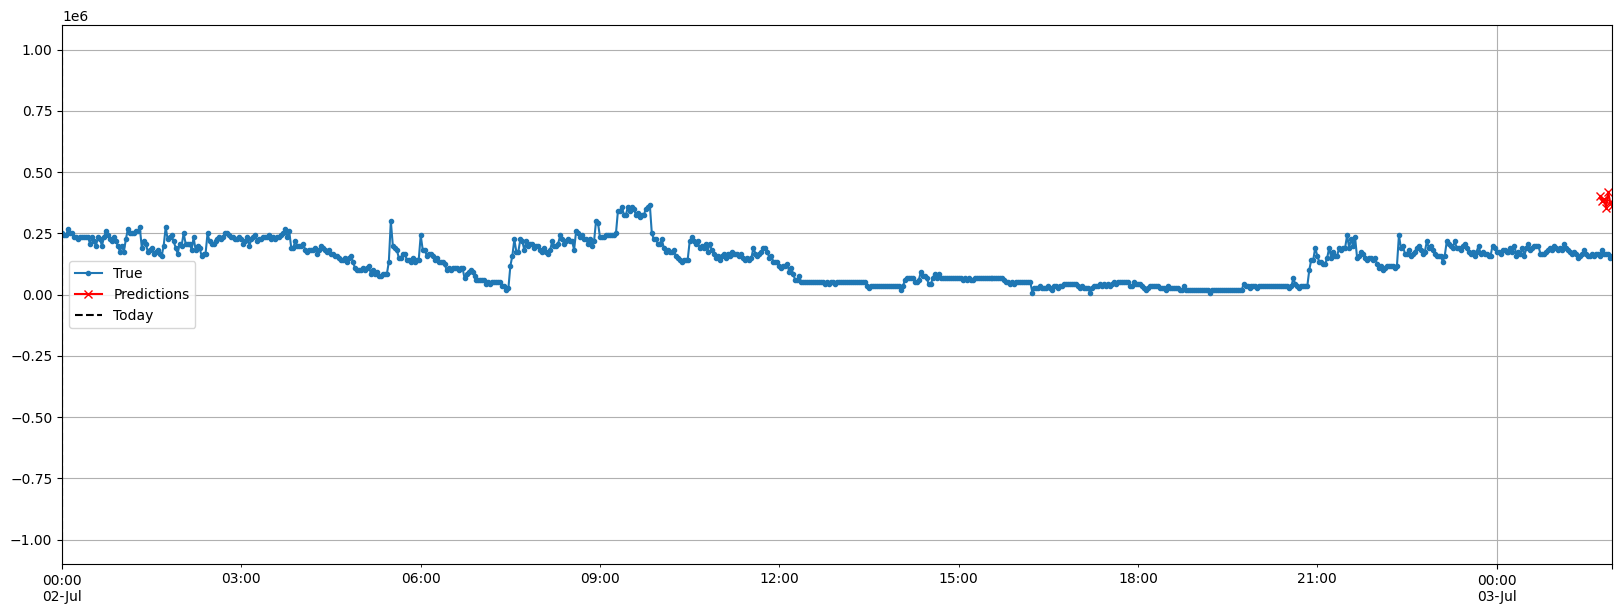

In [68]:
X = test.to_numpy()[np.newaxis, :sequence_lenght]
Y_pred = conv_rnn_model.predict(X)  # but then [0, -1] because only the last time step's output
Y_pred = pd.Series(Y_pred[0, -1], index=pd.date_range(start=ts.index[-sequence_lenght], end=ts.index[-1], freq=freq))

fig, ax = plt.subplots(figsize=(20, 7))
(ts * 1e6)[origin:end].plot(label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines(start, -1e6, 1e6, color="k", linestyle="--", label="Today")
#ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

## ARMA family



In [69]:
from statsmodels.tsa.arima.model import ARIMA

Check for stationarity with the Augmented Dickey-Fuller test

In [70]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train['avg_invocations_rate'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -14.718910110296255
p-value: 2.7717442830790136e-27


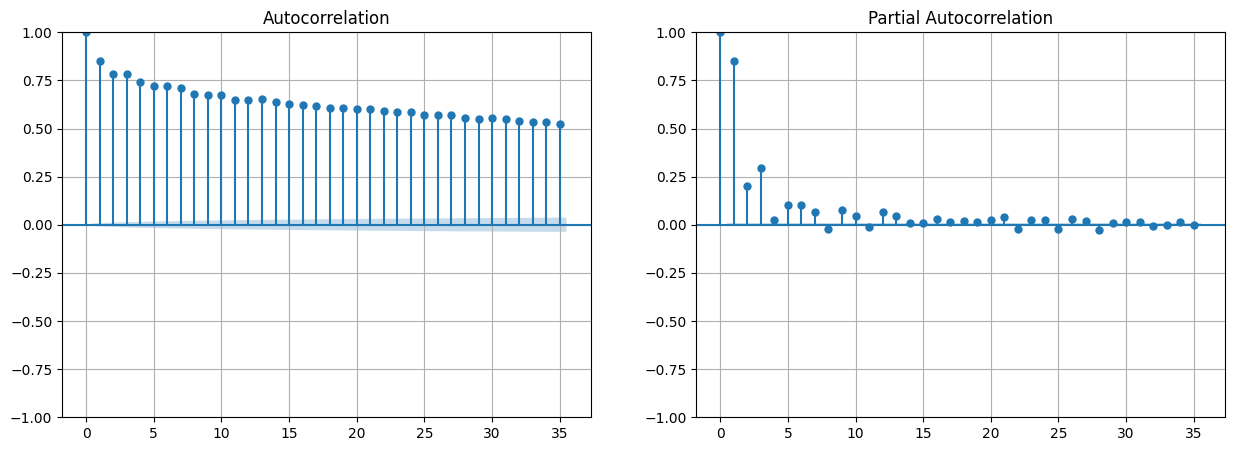

In [71]:
# extra code – shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(train['avg_invocations_rate'], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(train['avg_invocations_rate'], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

order=(p, d, q):
* p = the past p values of the time series, "how far back into the past the model should look";
* d = *order of integration*, running d consecutive rounds of differencing computes an approximation of the dth order derivative of the time series, so it will eliminate polynomial trends up to degree d.
* q = the past q forecast errors ε(t);

seasonal_order=(P, D, Q, s)
* P = , D = , Q =  : to model the time series at  (t–s), (t–2s), (t–3s);
* s = the period of the seasonal pattern.


In [72]:
trimmed_valid = ts.iloc[:-prediction_lenght]
# in realtà dal test risulta stazionaria, ma le performance sembrano migliori
arima = ARIMA(trimmed_valid, order=(1,1,1))
arima = arima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2min will be used.
  self._init_dates(dates, freq)


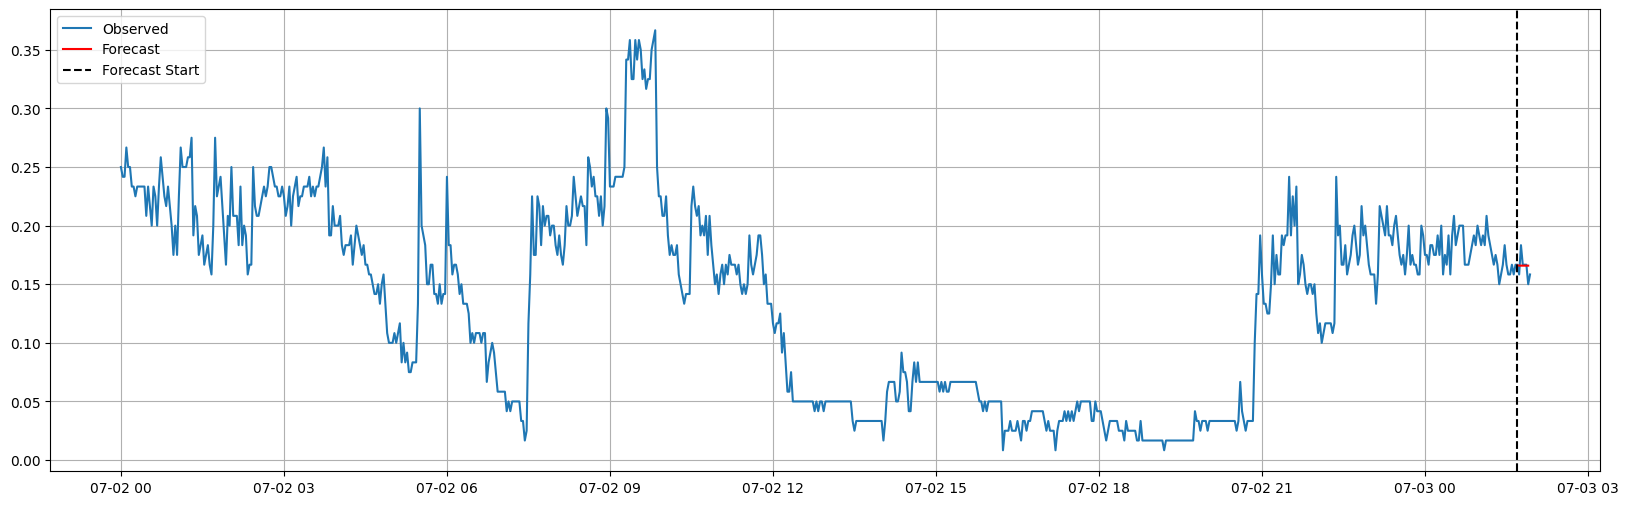

In [73]:
# Forecasting
forecast = arima.forecast(steps=prediction_lenght)

plt.figure(figsize=(20, 6))
# Plot the forecast
# original data: full length
plt.plot(ts.index, ts, label='Observed')
plt.plot(pd.date_range(trimmed_valid.index[-1], periods=prediction_lenght, freq=freq), forecast, label='Forecast', color='red')
plt.axvline(trimmed_valid.index[-1], linestyle='--', color='black', label='Forecast Start')
plt.legend()
plt.grid()
plt.show()

In [74]:
print(forecast)

2023-07-03 01:44:00    0.166036
2023-07-03 01:46:00    0.165892
2023-07-03 01:48:00    0.165859
2023-07-03 01:50:00    0.165852
2023-07-03 01:52:00    0.165850
2023-07-03 01:54:00    0.165850
2023-07-03 01:56:00    0.165850
Freq: 2min, Name: predicted_mean, dtype: float64
